### Construção e Solução de um modelo de Markov

Autor: João Marcos Torres Gardingo

In [143]:
%pip install networkx scipy pandas sympy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [144]:
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import numpy as np
import pandas as pd
from scipy.linalg import solve
import sympy as sp
import locale
import math

locale.setlocale(locale.LC_ALL, "pt_BR.UTF-8")


def generate_system(states, edges):
    state_to_index = {state: index for index, state in enumerate(states)}
    edge_list_index = [
        (state_to_index[src], state_to_index[dst], {"w": data["w"]})
        for (src, dst, data) in edges
    ]

    # Create a square matrix for the system of equations
    size = len(states)
    A = np.zeros((size, size))
    b = np.zeros(size)

    # Fill in the matrix A using the edge list
    for src, dst, data in edge_list_index:
        A[src][src] -= data["w"]  # Subtract weight from the diagonal (outgoing rate)
        A[dst][src] += data["w"]  # Add weight to the corresponding row (incoming rate)

    # Replace one equation with the conservation of probability
    A[-1] = np.ones(size)
    b[-1] = 1  # The sum of probabilities is equal to 1

    return A, b


def my_draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=None,
    label_pos=0.5,
    font_size=10,
    font_color="k",
    font_family="sans-serif",
    font_weight="normal",
    alpha=None,
    bbox=None,
    horizontalalignment="center",
    verticalalignment="center",
    ax=None,
    rotate=True,
    clip_on=True,
    rad=0,
):
    """Draw edge labels.

    Parameters
    ----------
    G : graph
        A networkx graph

    pos : dictionary
        A dictionary with nodes as keys and positions as values.
        Positions should be sequences of length 2.

    edge_labels : dictionary (default={})
        Edge labels in a dictionary of labels keyed by edge two-tuple.
        Only labels for the keys in the dictionary are drawn.

    label_pos : float (default=0.5)
        Position of edge label along edge (0=head, 0.5=center, 1=tail)

    font_size : int (default=10)
        Font size for text labels

    font_color : string (default='k' black)
        Font color string

    font_weight : string (default='normal')
        Font weight

    font_family : string (default='sans-serif')
        Font family

    alpha : float or None (default=None)
        The text transparency

    bbox : Matplotlib bbox, optional
        Specify text box properties (e.g. shape, color etc.) for edge labels.
        Default is {boxstyle='round', ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0)}.

    horizontalalignment : string (default='center')
        Horizontal alignment {'center', 'right', 'left'}

    verticalalignment : string (default='center')
        Vertical alignment {'center', 'top', 'bottom', 'baseline', 'center_baseline'}

    ax : Matplotlib Axes object, optional
        Draw the graph in the specified Matplotlib axes.

    rotate : bool (deafult=True)
        Rotate edge labels to lie parallel to edges

    clip_on : bool (default=True)
        Turn on clipping of edge labels at axis boundaries

    Returns
    -------
    dict
        `dict` of labels keyed by edge

    Examples
    --------
    >>> G = nx.dodecahedral_graph()
    >>> edge_labels = nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G))

    Also see the NetworkX drawing examples at
    https://networkx.org/documentation/latest/auto_examples/index.html

    See Also
    --------
    draw
    draw_networkx
    draw_networkx_nodes
    draw_networkx_edges
    draw_networkx_labels
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        ax = plt.gca()
    if edge_labels is None:
        labels = {(u, v): d for u, v, d in G.edges(data=True)}
    else:
        labels = edge_labels
    text_items = {}
    for (n1, n2), label in labels.items():
        (x1, y1) = pos[n1]
        (x2, y2) = pos[n2]
        (x, y) = (
            x1 * label_pos + x2 * (1.0 - label_pos),
            y1 * label_pos + y2 * (1.0 - label_pos),
        )
        pos_1 = ax.transData.transform(np.array(pos[n1]))
        pos_2 = ax.transData.transform(np.array(pos[n2]))
        linear_mid = 0.5 * pos_1 + 0.5 * pos_2
        d_pos = pos_2 - pos_1
        rotation_matrix = np.array([(0, 1), (-1, 0)])
        ctrl_1 = linear_mid + rad * rotation_matrix @ d_pos
        ctrl_mid_1 = 0.5 * pos_1 + 0.5 * ctrl_1
        ctrl_mid_2 = 0.5 * pos_2 + 0.5 * ctrl_1
        bezier_mid = 0.5 * ctrl_mid_1 + 0.5 * ctrl_mid_2
        (x, y) = ax.transData.inverted().transform(bezier_mid)

        if rotate:
            # in degrees
            angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360
            # make label orientation "right-side-up"
            if angle > 90:
                angle -= 180
            if angle < -90:
                angle += 180
            # transform data coordinate angle to screen coordinate angle
            xy = np.array((x, y))
            trans_angle = ax.transData.transform_angles(
                np.array((angle,)), xy.reshape((1, 2))
            )[0]
        else:
            trans_angle = 0.0
        # use default box of white with white border
        if bbox is None:
            bbox = dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0))
        if not isinstance(label, str):
            label = str(label)  # this makes "1" and 1 labeled the same

        t = ax.text(
            x,
            y,
            label,
            size=font_size,
            color=font_color,
            family=font_family,
            weight=font_weight,
            alpha=alpha,
            horizontalalignment=horizontalalignment,
            verticalalignment=verticalalignment,
            rotation=trans_angle,
            transform=ax.transData,
            bbox=bbox,
            zorder=1,
            clip_on=clip_on,
        )
        text_items[(n1, n2)] = t

    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )

    return text_items


def filter_duplex_edges(edges):
    # Store edges in a dictionary with the nodes as keys (in a tuple, order matters) and weights as values
    edge_dict = {(src, dst): data["w"] for src, dst, data in edges}
    # Find duplex edges where both (a, b) and (b, a) exist
    duplex_edges = []
    for (src, dst), weight in edge_dict.items():
        if (dst, src) in edge_dict:
            duplex_edges.append((src, dst, {"w": weight}))

    duplex_copy = duplex_edges.copy()

    for src, dst, _ in duplex_copy:
        duplex_copy.remove((dst, src, {"w": edge_dict[(dst, src)]}))

    return duplex_copy


def generate_states(N, K):
    # Generate all combinations of N users distributed across K resources
    # Each combination will be a tuple where the sum of the numbers is N
    # and the length of the tuple is K.
    # For example, if N=2 and K=3, one possible state could be (0, 2, 0)
    # which means 0 users in the first resource, 2 in the second, and 0 in the third.

    # The states are generated using a product function which considers repetition.
    # This is because each resource can have a number from 0 to N users.
    # The filter is used to ensure that the sum of users in each state is exactly N.

    state_list = list(
        filter(lambda x: sum(x) == N, itertools.product(range(N + 1), repeat=K))
    )
    state_list.reverse()
    return state_list


def generate_states2(N, K, max_users_per_resource):
    """
    Generate all combinations of N users distributed across K resources, with
    each resource having a maximum number of users specified by max_users_per_resource.

    Parameters:
    N (int): Total number of users.
    K (int): Number of resources.
    max_users_per_resource (list): A list containing the maximum number of users for each resource.

    Returns:
    List of tuples representing all possible states.
    """

    # Check if max_users_per_resource has K elements
    if len(max_users_per_resource) != K:
        raise ValueError("max_users_per_resource must have K elements.")

    # Generate product with limits for each resource
    ranges = [range(min(N + 1, limit + 1)) for limit in max_users_per_resource]

    # Generate all possible combinations given the individual resource limits
    state_list = [state for state in itertools.product(*ranges) if sum(state) == N]
    state_list.reverse()
    return state_list


def generate_states_birthdeath(M):
    state_list = [i for i in range(0, M + 1)]
    return state_list


def generate_edges_old(states, S):
    """
    Generate a list of edges with weights between the states based on service times S.
    The weights are determined by the number of transactions per minute each resource can complete.
    """
    edge_list = []
    weights = [60 / s for s in S]  # Calculate weights based on service times

    # Map the states to their index in the states list for easy lookup
    state_to_index = {state: index for index, state in enumerate(states)}

    # Define transition probabilities for moving from CPUs to resources and back
    transition_probs = {
        "CPU_to_resource": 1
        / (len(S) - 1),  # Assuming equal probability to any resource
        "resource_to_CPU": 1,  # Always moving back to CPU
    }

    # Iterate through each state to create edges according to the system rules
    for state in states:
        # Iterate through all possible transitions
        for i in range(len(S)):
            if state[i] > 0:  # There is at least one user in the current resource
                for j in range(len(S)):
                    if i == j:  # Skip if it's the same resource
                        continue

                    # Moving from resource i to resource j (including CPU)
                    if i != 0 and j != 0:
                        continue
                    else:
                        next_state = list(state)
                        next_state[i] -= 1
                        next_state[j] += 1
                        next_state = tuple(next_state)

                    if next_state in state_to_index:
                        if i == 0:  # Transition from CPU to resource
                            prob = transition_probs["CPU_to_resource"]
                        else:  # Transition from resource to CPU
                            prob = transition_probs["resource_to_CPU"]
                        weight = weights[i] * prob
                        edge_list.append(
                            (
                                state_to_index[state],
                                state_to_index[next_state],
                                {"w": float(f"{weight:.2f}")},
                            )
                        )
    edges = [(states[src], states[dst], attr) for src, dst, attr in edge_list]
    return edges


def generate_edges(
    N, S, states, transition_probs, transition_type="discrete", factor=60
):
    edge_list = []
    weights = [
        factor / s if transition_type == "continuous" else 1 for s in S
    ]  # Calculate weights based on service times

    # Map the states to their index in the states list for easy lookup
    state_to_index = {state: index for index, state in enumerate(states)}

    # Iterate through each state to create edges according to the system rules
    for state in states:
        # Iterate through all possible transitions
        for i in range(len(S)):
            if state[i] > 0:  # There is at least one user in the current resource
                for j in range(len(S)):
                    # Skip if it's the same resource or transition is not allowed
                    if i == j or (i, j) not in transition_probs:
                        continue

                    next_state = list(state)
                    next_state[i] -= 1
                    next_state[j] += 1
                    next_state = tuple(next_state)

                    if next_state in state_to_index:
                        state_has_N = N in state
                        weight = (
                            weights[i]
                            * transition_probs[(i, j)]
                            * (
                                N
                                if state_has_N and transition_type == "discrete"
                                else 1
                            )
                        )
                        edge_list.append(
                            (
                                state_to_index[state],
                                state_to_index[next_state],
                                {"w": float(f"{weight:.2f}")},
                            )
                        )
    edges = [(states[src], states[dst], attr) for src, dst, attr in edge_list]
    return edges


def generate_edges3(
    states,
    service_rates,
    lambda_system,
    transition_probs,
    resources,
    transition_origins={},
):
    edge_list = []
    weights = [
        (1 / s) for s in service_rates
    ]  # Calculate weights based on service times

    initial_resources = [
        transition[1] for transition in transition_probs if transition[0] is None
    ]
    initial_states = [state for state in states if state[0] in initial_resources]
    resources_index = {index: resource for index, resource in enumerate(resources)}

    # Arestas de chegada no sistema
    for state in states:
        # Para o estado inicial onde todos os servidores estão livres (representado por zeros)

        if state in initial_states:
            # Crie arestas para cada servidor possível com sua respectiva probabilidade
            for i in range(len(service_rates)):
                if transition_probs.get((None, i)) is not None:
                    next_state = list(state)
                    next_state[i] += 1
                    next_state = tuple(next_state)
                    if next_state in states:
                        if (None, i) in transition_origins:
                            if transition_origins[(None, i)] == state:
                                edge_list.append(
                                    (
                                        state,
                                        next_state,
                                        {
                                            "w": lambda_system
                                            * transition_probs[(None, i)]
                                        },
                                    )
                                )
                        else:
                            edge_list.append(
                                (
                                    state,
                                    next_state,
                                    {"w": lambda_system * transition_probs[(None, i)]},
                                )
                            )
        # Para os outros estados onde as transições ocorrem de servidor para servidor

        # Transições entre outros servidores após o serviço
        for i in range(len(service_rates)):
            if state[i] > 0:
                for transition in transition_probs:
                    if transition[0] == i:
                        next_state = list(state)
                        next_state[i] = (
                            next_state[i] - 1
                            if next_state[i]
                            > resources[resources_index[i]]["min_users"]
                            else next_state[i]
                        )

                        if transition[1] is None:
                            next_state = tuple(next_state)
                            if next_state in states:
                                edge_list.append(
                                    (
                                        state,
                                        next_state,
                                        {
                                            "w": weights[i]
                                            * transition_probs[transition]
                                        },
                                    )
                                )
                            continue

                        next_state[transition[1]] = (
                            next_state[transition[1]] + 1
                            if next_state[transition[1]]
                            < resources[resources_index[transition[1]]]["max_users"]
                            else next_state[transition[1]]
                        )
                        next_state = tuple(next_state)
                        if (
                            all(users == 0 for users in next_state)
                            or next_state not in states
                        ):
                            continue

                        edge_list.append(
                            (
                                state,
                                next_state,
                                {"w": weights[i] * transition_probs[transition]},
                            )
                        )
    return edge_list


def generate_edges_birthdeath(states, lambdas, mus):
    """
    Generate a list of edges with weights between the states based on service times S.
    The weights are determined by the number of transactions per minute each resource can complete.
    """
    edges = []

    # Iterate through each state to create edges according to the system rules
    for state in range(0, len(states) - 1):
        # Iterate through all possible transitions

        edges.append((state, state + 1, {"w": lambdas[state]}))
        edges.append((state + 1, state, {"w": mus[state]}))
    return edges


def layout_states(states, N):
    """
    Organize states in a layout with levels:
    - Top level: State with all users in CPU (e.g., (N, 0, ..., 0))
    - Subsequent levels: States with fewer users in CPU and more in resources
    """
    levels = {i: [] for i in range(N + 1)}  # Dictionary to hold states at each level

    # Assign states to levels based on the number of users in the CPU
    for state in states:
        cpu_users = state[0]
        levels[cpu_users].append(state)

    # Calculate positions based on levels and states in each level
    pos = {}
    for level in range(N, -1, -1):  # Start from top level and go down
        num_states = len(levels[level])
        x_positions = np.linspace(
            -num_states / 2.0 + 0.5, num_states / 2.0 - 0.5, num_states
        )
        for i, state in enumerate(
            sorted(levels[level], key=lambda x: x[1:], reverse=True)
        ):
            pos[state] = (x_positions[i], level)

    return pos


def layout_states_birthdeath(states, M):
    pos = {}
    x_positions = np.linspace(-(M + 1) / 2.0 + 0.5, (M + 1) / 2.0 - 0.5, (M + 1))

    for state in states:
        pos[state] = (x_positions[state], 0)

    return pos


# Function to determine curvature direction based on node positions
def get_curvature(u, v, pos, must_bend):
    left_side = pos[u][0] > pos[v][0]
    if must_bend:
        return 0.3 if left_side else -0.3
    else:
        return -0.3 if left_side else 0.3


def solveSystem(A, b, states):
    probabilities = solve(A, b)
    probabilities_dict = {}
    for i, probability in enumerate(probabilities):
        probabilities_dict[states[i]] = f"{probability:.4f}"
    df = pd.DataFrame(probabilities_dict.items(), columns=["Estado", "Probabilidade"])
    display(df)
    return probabilities_dict


def draw_network_graph(K, N, states, edges, filename):
    NODE_SIZE = 1000 * K
    G = nx.DiGraph()

    # Add the states as nodes to the graph
    for state in states:
        G.add_node(state)

    G.add_edges_from(edges)
    pos = layout_states(states, N)  # Use the previously defined layout
    _, ax = plt.subplots(figsize=(15, 10))  # Increase figure size

    nx.draw_networkx_nodes(
        G, pos, ax=ax, node_color="#6ED0EE", node_size=NODE_SIZE, node_shape="o"
    )
    nx.draw_networkx_labels(G, pos, ax=ax)

    duplex_edges = filter_duplex_edges(edges)

    # Draw edges with curvature
    for u, v, data in G.edges(data=True):
        must_bend = (u, v, {"w": data["w"]}) in duplex_edges
        rad = get_curvature(u, v, pos, must_bend) if must_bend else 0
        style = f"arc3,rad={rad}"
        nx.draw_networkx_edges(
            G,
            pos,
            ax=ax,
            edgelist=[(u, v)],
            connectionstyle=style,
            arrowsize=20,
            node_size=NODE_SIZE,
        )

        if must_bend:
            my_draw_networkx_edge_labels(
                G, pos, ax=ax, edge_labels={(u, v): data["w"]}, rotate=False, rad=rad
            )

    # Custom edge labels
    edge_weights = nx.get_edge_attributes(G, "w")

    not_bending_edges = [
        (u, v)
        for u, v, data in G.edges(data=True)
        if (u, v, {"w": data["w"]}) not in duplex_edges
    ]
    nx.draw_networkx_edges(
        G, pos, ax=ax, edgelist=not_bending_edges, arrowsize=20, node_size=NODE_SIZE
    )
    not_bending_labels = {edge: edge_weights[edge] for edge in not_bending_edges}
    nx.draw_networkx_edge_labels(
        G, pos, ax=ax, edge_labels=not_bending_labels, rotate=False
    )

    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"{filename}.png", dpi=300)  # Increase the resolution
    plt.show()


def draw_network_graph_birthdeath(M, states, edges, filename, dpi=300):
    NODE_SIZE = 1000
    G = nx.DiGraph()

    # Add the states as nodes to the graph
    for state in states:
        G.add_node(state)

    G.add_edges_from(edges)
    pos = layout_states_birthdeath(states, M)  # Use the previously defined layout
    _, ax = plt.subplots(figsize=(15, 10))  # Increase figure size

    nx.draw_networkx_nodes(
        G, pos, ax=ax, node_color="#6ED0EE", node_size=NODE_SIZE, node_shape="o"
    )
    nx.draw_networkx_labels(G, pos, ax=ax)

    # Draw edges with curvature
    for u, v, data in G.edges(data=True):
        rad = -0.3 if v > u else -0.3
        style = f"arc3,rad={rad}"
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=[(u, v)], alpha=0)
        nx.draw_networkx_edges(
            G,
            pos,
            ax=ax,
            edgelist=[(u, v)],
            connectionstyle=style,
            arrowsize=20,
            node_size=NODE_SIZE,
        )
        my_draw_networkx_edge_labels(
            G, pos, ax=ax, edge_labels={(u, v): data["w"]}, rotate=False, rad=rad
        )

    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"{filename}.png", dpi=dpi)  # Increase the resolution
    plt.show()


def calculate_metrics(
    N, K, probabilities, service_times, multiprog_level={}, custom_labels=[], factor=60
):
    # Calculate U_cpu using probabilities of states with at least one user in CPU and system resources:
    U_dict = {}
    labels_provided = len(custom_labels) == len(service_times)

    for i in range(0, K):
        key = (
            f"U_{custom_labels[i]}"
            if labels_provided
            else "U_CPU"
            if i == 0
            else f"U_disk{i}"
        )
        resource = key.removeprefix("U_")
        U_dict[
            key
        ] = f"{(sum(float(((float(prob) / multiprog_level[resource][1]) if state[multiprog_level[resource][0]] == 1 else prob) if (resource in multiprog_level) else prob) for state, prob in probabilities.items() if state[i] > 0)):.4f}"

    # Service rate is the inverse of service time for the CPU
    mu_cpu = 1 / service_times[0]  # transactions per unit of time

    # Convert to transactions per minute by multiplying by 60
    mu_cpu_per_unit = mu_cpu * factor

    # X_0 is the throughput for the CPU
    X_0 = (
        float(U_dict[f"U_{custom_labels[0] if labels_provided else 'CPU'}"])
        * mu_cpu_per_unit
    )

    # Using Little's Law to calculate response time R
    # R = N / X_0, where N is the number of users
    R = N / X_0  # in minutes
    R_unit = f"{(R * factor):.4f}"  # Convert to seconds

    return U_dict, X_0, R_unit


def calculate_metrics2(
    K, probabilities, service_times, resources, multiprog_level={}, factor=60
):
    U_dict = {}
    X_dict = {}
    custom_labels = list(resources)
    labels_provided = len(custom_labels) == len(service_times)

    for i in range(0, K):
        key = custom_labels[i] if labels_provided else "CPU" if i == 0 else f"disk{i}"
        prob_sum = []
        for state, prob in probabilities.items():
            if state[i] <= 0:
                continue

            if key in multiprog_level:
                if state[resources[key]] == 1:
                    prob_sum.append(float(prob) / multiprog_level[key])
                else:
                    prob_sum.append(float(prob))
            else:
                prob_sum.append(float(prob))

        # U_dict[key] = f"{(sum(float(((float(prob) / multiprog_level[key][1]) if state[multiprog_level[key][0]] == 1 else prob) if has_multiprog_level else prob) for state, prob in probabilities.items() if state[i] > 0)):.4f}"
        U_dict[key] = f"{(sum(prob for prob in prob_sum)):.4f}"
        X_dict[key] = float(f"{(float(U_dict[key]) * factor / service_times[i]):.4f}")

    return U_dict, X_dict


def calculate_metrics3(
    K,
    initial_states,
    probabilities,
    service_times,
    resources,
    multiprog_level={},
    factor=1,
    lambda_system=0.5,
):
    U_dict = {}
    X_dict = {}
    custom_labels = list(resources)
    labels_provided = len(custom_labels) == len(service_times)

    for i in range(0, K):
        key = custom_labels[i] if labels_provided else "CPU" if i == 0 else f"disk{i}"
        prob_sum = []
        for state, prob in probabilities.items():
            if state[i] <= 0:
                continue

            if key in multiprog_level:
                if state[resources[key]["index"]] == 1:
                    prob_sum.append(float(prob) / multiprog_level[key])
                else:
                    prob_sum.append(float(prob))
            else:
                prob_sum.append(float(prob))

        U_dict[key] = f"{(sum(prob for prob in prob_sum)):.4f}"
        X_dict[key] = float(f"{(float(U_dict[key]) * factor / service_times[i]):.4f}")

    N = sum(float(prob) * sum(state) for state, prob in probabilities.items())
    N_unit = f"{N:.4f}"

    # Calculate X_0 using probabilities of states with at least one user in CPU and system resources:
    X_0 = 0
    for state in initial_states:
        X_0 += float(probabilities[state]) * lambda_system

    # Calculate R using Little's Law
    R = N / X_0
    R_unit = f"{(R * factor):.4f}"

    return U_dict, X_dict, N_unit, X_0, R_unit


def calculate_birth_death_metrics(B, lambda_system, mus, probabilities):
    # Calcula o tamanho da fila
    N = sum(state * float(prob) for state, prob in probabilities.items())

    # Taxa de clientes que não entram no sistema (perda)
    loss_rate = lambda_system * float(probabilities[B])

    # Taxa de clientes que entram no sistema (X_0)
    X_0 = 0
    for i in range(1, B + 1):
        X_0 += mus[i - 1] * float(probabilities[i])

    # Tempo médio de resposta (R)
    R = N / X_0

    U = 1 - float(probabilities[0])

    return {
        "N": N,
        "loss_rate": loss_rate,
        "X_0": X_0,
        "R": R,
        "U": U,
    }


def calculate_metrics_MM1(lambda_, mu, n=1, q=90):
    """
    Calculate metrics for an M/M/1 queue theory process.

    Parameters:
    lambda_: arrival rate value
    mu: service rates for each state
    n: number of requests or customers in the system that you want to calculate the probability
    q: percentile value for the response and wait time

    Returns:
    Dictionary of calculated metrics
    """

    rho = float(lambda_ / mu)

    # Calcula a probabilidade de 0 clientes no sistema:
    P_0 = float(1 - rho)

    # Calcula a probabilidade de exatamente n clientes no sistema:
    P_n = P_0 * rho**n

    # Calcula o número médio de clientes no sistema E(n)
    E_n = rho / (1 - rho)

    # A variância do número de req ou clientes no sistema é:
    Var_n = rho / ((1 - rho) ** 2)

    # Calcula a probabilidade de n ou mais req ou clientes no sistema é:
    Prob_n_ou_mais = rho**n

    # Calcula tempo médio de resposta do sistema E(r)
    E_r = (1 / mu) / P_0

    # O tempo médio de espera na fila é:
    E_w = rho * E_r

    # A variância do tempo médio de espera na fila é:
    Var_w = (2 - rho) * rho / (mu**2 * (1 - rho) ** 2)
    
    # A variância do tempo médio de resposta do sistema é:
    Var_r = 1 / mu**2 / (1-rho)**2

    # O q-percentil do tempo de resposta é:
    r_q = (1 / (mu * (1 - rho))) * np.log(100 / (100 - q))

    # O q-percentil do tempo de espera é:
    w_q = max(0, E_w / rho * np.log(100 * rho / (100 - q)))

    # A função da distribuição acumulada (CDF) do tempo de resposta é:
    # F_r = 1 - np.exp(-r_q * mu * (1 - rho))

    # A CDF do tempo de espera é:
    # F_w = 1 - rho * np.exp(-r_q * mu * (1 - rho))

    E_nq = rho**2 / (1 - rho)

    E_ns = E_n - E_nq

    E_s = E_r - E_w

    results = {
        "λ": lambda_,
        "μ": mu,
        "ρ = U": f"{rho:.4f}",
        "P_0": f"{P_0:.4f}",
        "P_n": f"{P_n:.4f}",
        f"Prob de {n} ou + clientes no sistema": f"{Prob_n_ou_mais:.4f}",
        "E[n] (Número médio de clientes no sistema)": f"{E_n:.4f}",
        "Var[n] (Variância do número de clientes no sistema)": f"{Var_n:.4f}",
        "E[nq] (Número de clientes na fila)": f"{E_nq:.4f}",
        "E[ns] (Número de clientes em serviço)": f"{E_ns:.4f}",
        "E[r] (tempo médio de resposta)": f"{E_r:.4f}",
        "Var[r] (Variância do tempo médio de resposta)": f"{Var_r:.4f}",
        "E[w] (tempo médio de espera na fila)": f"{E_w:.4f}",
        "Var[w] (Variância do tempo médio de espera na fila)": f"{Var_w:.4f}",
        "E[s] (tempo médio de serviço)": f"{E_s:.4f}",
        "rq (q-percentil do tempo de resposta)": f"{r_q:.4f}",
        "wq (q-percentil do tempo de espera)": f"{w_q:.4f}",
    }

    display(pd.DataFrame(list(results.items()), columns=["Métrica", "Valor"]))

    return results


def calculate_P0_MMm(m, rho):
    # Calculate the sum part of the formula
    sum_part = sum(((m * rho) ** n / math.factorial(n)) for n in range(1, m))

    # Calculate P0 using the formula
    P0 = 1 / (1 + (m * rho) ** m / (math.factorial(m) * (1 - rho)) + sum_part)

    return P0


def calculate_metrics_MMm(lambda_, mu, m, n=1, q=90):
    """
    Calculate metrics for an M/M/m queue theory process.

    Parameters:
    lambda_: arrival rate value
    mu: service rates for each state
    m: Maximum number of resources available for rent
    n: number of requests or customers in the system that you want to calculate the probability
    q: percentile value for the response and wait time

    Returns:
    Dictionary of calculated metrics
    """

    # A intensidade de tráfego e utilização do sistema é dada por
    rho = lambda_ / (m * mu)

    # Probabilidade de ter 0 tarefas no sistema
    P_0 = calculate_P0_MMm(m, rho)

    # Probabilidade de ter n tarefas no sistema
    P_n = (
        ((m * rho) ** n / math.factorial(n)) * P_0
        if n < m
        else ((rho**n * m**m) / math.factorial(n)) * P_0
    )

    # A probabilidade de que uma tarefa que chegue tenha que esperar é:
    varrho = P_0 * ((m * rho) ** m) / (math.factorial(m) * (1 - rho))

    # O número médio de tarefas na fila é:
    E_nq = varrho * rho / (1 - rho)

    # O número médio de tarefas em serviço é:
    E_ns = m * rho

    # O número médio de tarefas no sistema é:
    E_n = E_nq + E_ns

    # Variância do número médio de tarefas no sistema
    Var_n = m * rho + rho * varrho * ((1 + rho - rho * varrho) / ((1 - rho) ** 2) + m)

    # Variância do número médio de tarefas na fila
    Var_nq = rho * varrho * ((1 + rho - rho * varrho) / ((1 - rho) ** 2))

    # O tempo médio de resposta é
    E_r = E_n / lambda_
    
    # A variância do tempo médio de resposta é:
    Var_r = 1 / mu**2 * (1 + (varrho * (2 - varrho)) / (m**2 * (1 - rho)**2))

    # A variância do tempo médio de espera na fila é:
    Var_w = varrho * (2 - varrho) / (m**2 * mu**2 * (1 - rho)**2)
    
    # O tempo médio de espera na fila é:
    E_w = E_nq / lambda_

    # O tempo médio em serviço é:
    E_s = E_r - E_w

    # Função de distribuição acumulada de r, para r>0:
    # F_r = (
    #     1 - np.exp(mu * r) - varrho * mu * r * np.exp(-mu * r)
    #     if rho == ((m - 1) / m)
    #     else 1
    #     - np.exp(-mu * r)
    #     - (varrho / (1 - m + m * p))
    #     * (np.exp(-m * mu * r * (1 - rho)) - np.exp(-mu * r))
    # )

    # O q-percentil do tempo médio de espera é dado por:
    w_q = max(0, 1 / (m * mu * (1 - rho)) * np.log(100 * varrho / (100 - q)))
    
    results = {
        "λ": lambda_,
        "μ": mu,
        "ρ = U": f"{rho:.4f}",
        "ϱ = Probabilidade de que um cliente que chegue tenha que esperar é": f"{varrho:.4f}",
        "P_0": f"{P_0:.4f}",
        "P_n": f"{P_n:.4f}",
        "E[n] (Número médio de clientes no sistema)": f"{E_n:.4f}",
        "Var[n] (Variância do número de clientes no sistema)": f"{Var_n:.4f}",
        "Var[nq] (Variância do número de clientes na fila)": f"{Var_nq:.4f}",
        "Var[r] (Variância do tempo de resposta no sistema)": f"{Var_r:.4f}",
        "Var[w] (Variância do tempo de espera na fila)": f"{Var_w:.4f}",
        "E[nq] (Número de clientes na fila)": f"{E_nq:.4f}",
        "E[ns] (Número de clientes em serviço)": f"{E_ns:.4f}",
        "E[r] (tempo médio de resposta)": f"{E_r:.4f}",
        "E[w] (tempo médio de espera na fila)": f"{E_w:.4f}",
        "E[s] (tempo médio de serviço)": f"{E_s:.4f}",
        "wq (q-percentil do tempo de espera)": f"{w_q:.4f}",
        "wq (lado direito (ln))": f"{(1 / (m * mu * (1 - rho)) * np.log(100 * varrho / (100 - q))):.4f}",
    }

    display(pd.DataFrame(list(results.items()), columns=["Métrica", "Valor"]))

    return results


def calculate_P0_MMmB(rho, m, B):
    if m == 1:
        return (1 - rho) / (1 - rho ** (B + 1)) if rho != 1 else 1 / (B + 1)

    # Calculate the sum part of the formula
    sum_part = sum(((m * rho) ** n / math.factorial(n)) for n in range(1, m))

    # Calculate P0 using the formula
    P0 = 1 / (
        1
        + ((1 - rho ** (B - m + 1)) * (m * rho) ** m)
        / (math.factorial(m) * (1 - rho))
        + sum_part
    )

    return P0


def calculate_Pn_MMmB(P_0, rho, m, n, B):
    if m == 1:
        (1 - rho) / (1 - rho**(B+1)) * rho ** n if rho != 1 else 1 / (B+1) if 0 <= n <= B else 0
    
    if 0 < n < m:
        return ((m * rho) ** n / math.factorial(n)) * P_0
    
    if m <= n <= B:
        return ((rho**n * m**m) / math.factorial(m)) * P_0
    
    return 0

def calculate_En_MMmB(P_0, rho, m, B, exp=1):
    return sum(n**exp * calculate_Pn_MMmB(P_0, rho, m, n, B) for n in range(1, B + 1))
    
def calculate_metrics_MMmB(lambda_, mu, m, B, n=1, q=90):
    """
    Calculate metrics for an M/M/m queue theory process.

    Parameters:
    lambda_: arrival rate value
    mu: service rates for each state
    m: Maximum number of resources available for rent
    B: Buffer size
    n: number of requests or customers in the system that you want to calculate the probability
    q: percentile value for the response and wait time

    Returns:
    Dictionary of calculated metrics
    """

    # A intensidade de tráfego e utilização do sistema é dada por
    rho = float(lambda_ / (m * mu))

    # Probabilidade de ter 0 tarefas no sistema
    P_0 = calculate_P0_MMmB(rho, m, B)

    # Probabilidade de ter n tarefas no sistema
    P_n = calculate_Pn_MMmB(P_0, rho, m, n, B)
    
    # A probabilidade do sistema estar cheio é:
    P_m = (m * rho)**m / math.factorial(m) * P_0
    
    # O número médio de tarefas no sistema é:
    E_n = calculate_En_MMmB(P_0, rho, m, B)
    
    # O número médio de tarefas na fila é:
    E_nq = sum((n-m) * calculate_Pn_MMmB(P_0, rho, m, n, B) for n in range(m+1, B + 1))
    
    # O número médio de tarefas em serviço é:
    E_ns = E_n - E_nq
    
    # A taxa de tarefas que estão realmente entrando no sistema (taxa de chegada efetiva) é:
    Ef_lambda = lambda_ * (1 - calculate_Pn_MMmB(P_0, rho, m, B, B))
    
    # A utilização do sistema é dada por:
    U = Ef_lambda / (m * mu)

    # A probabilidade de que uma tarefa que chegue tenha que esperar é:
    varrho = P_0 * ((m * rho) ** m) / (math.factorial(m) * (1 - rho))

    # Variância do número médio de tarefas no sistema
    Var_n = calculate_En_MMmB(P_0, rho, m, B, exp=2) - E_n**2

    # Variância do número médio de tarefas na fila
    Var_nq = rho * varrho * ((1 + rho - rho * varrho) / ((1 - rho) ** 2))

    # o tempo médio de resposta é
    E_r = E_n / Ef_lambda

    # o tempo médio de espera é:
    E_w = E_nq / Ef_lambda

    # o tempo médio de serviço é:
    E_s = E_r - E_w

    # Função de distribuição acumulada de r, para r>0:
    # F_r = (
    #     1 - np.exp(mu * r) - varrho * mu * r * np.exp(-mu * r)
    #     if rho == ((m - 1) / m)
    #     else 1
    #     - np.exp(-mu * r)
    #     - (varrho / (1 - m + m * p))
    #     * (np.exp(-m * mu * r * (1 - rho)) - np.exp(-mu * r))
    # )

    # O q-percentil do tempo médio de espera é dado por:
    w_q = max(0, 1 / (m * mu * (1 - rho)) * np.log(100 * varrho / (100 - q)))

    results = {
        "λ": f"{lambda_:.4f}",
        "λ' taxa efetiva": f"{Ef_lambda:.4f}",
        "μ": f"{mu:.4f}",
        "ρ": f"{rho:.4f}",
        "U (Utilização)": f"{U:.4f}",
        "ϱ = Probabilidade de que um cliente que chegue tenha que esperar é": f"{varrho:.4f}",
        "P_0": f"{P_0:.4f}",
        "P_n": f"{P_n:.4f}",
        "P_m": f"{P_m:.4f}",
        "E[n] (Número médio de clientes no sistema)": f"{E_n:.4f}",
        "Var[n] (Variância do número de clientes no sistema)": f"{Var_n:.4f}",
        "Var[nq] (Variância do número de clientes na fila)": f"{Var_nq:.4f}",
        "E[nq] (Número de clientes na fila)": f"{E_nq:.4f}",
        "E[ns] (Número de clientes em serviço)": f"{E_ns:.4f}",
        "E[r] (tempo médio de resposta)": f"{E_r:.4f}",
        "E[w] (tempo médio de espera na fila)": f"{E_w:.4f}",
        "E[s] (tempo médio de serviço)": f"{E_s:.4f}",
        "wq (q-percentil do tempo de espera)": f"{w_q:.4f}",
    }

    display(pd.DataFrame(list(results.items()), columns=["Métrica", "Valor"]))

    return results

def find_m_by_restrictions(w_q, lambda_, mu, varrho, q):
    m = sp.symbols("m")
    w_q_expr = 1 / (m*mu*(1 - (lambda_ / (m*mu)))) * np.log(100 * varrho / (100 - q))
    # E_w = varrho / (m*mu*(1 - (lambda_ / (m*mu))))
    
    # Solve for m
    solution = sp.solve(w_q_expr - w_q, m)
    print(solution)
    
def F_w_MMm(varrho, m, mu, rho, w):
    return 1 - varrho*np.exp(-m * mu * (1 - rho) * w)    
    

In [145]:
# EX 5

mu = 1 / 5
lambda_ = 36/60
m = 7
q = 5

results = calculate_metrics_MMm(lambda_, mu, m, q=95)
rho = 0.4286
varrho = 0.0376

Prob = 1 -  F_w_MMm(varrho, m, mu, rho, w=1)

print("Probabilidade do tempo de espera ser > 1 min: ", f"{Prob:.4f}")

,Métrica,Valor
0,λ,0.6
1,μ,0.2
2,ρ = U,0.4286
3,ϱ = Probabilidade de que um cliente que chegue...,0.0376
4,P_0,0.0496
5,P_n,0.1487
6,E[n] (Número médio de clientes no sistema),3.0282
7,Var[n] (Variância do número de clientes no sis...,3.1827
8,Var[nq] (Variância do número de clientes na fila),0.0698
9,Var[r] (Variância do tempo de resposta no sist...,25.1154


Probabilidade do tempo de espera ser > 1 min:  0.0169


In [146]:
# EX 4
lambda1 = 5

A = [[1, -0.5], [-1, 1 ]]
b = [11.6667, 16.6667]

[lambda2, lambda3] = solve(A, b)

lambda2 = float(f"{lambda2:.3f}")
lambda3 = float(f"{lambda3:.3f}")

mu1 = 10
mu2 = 50
mu3 = 100

print(f"λ1: {lambda1}", f"\nλ2: {lambda2}", f"\nλ3: {lambda3}")

print("Resultados fila 1")
results1 = calculate_metrics_MM1(lambda1, mu1)

print("Resultados fila 2")
results2 = calculate_metrics_MM1(lambda2, mu2)

print("Resultados fila 3")
results3 = calculate_metrics_MM1(lambda3, mu3)

λ1: 5 
λ2: 40.0 
λ3: 56.667
Resultados fila 1


,Métrica,Valor
0,λ,5
1,μ,10
2,ρ = U,0.5000
3,P_0,0.5000
4,P_n,0.2500
5,Prob de 1 ou + clientes no sistema,0.5000
6,E[n] (Número médio de clientes no sistema),1.0000
7,Var[n] (Variância do número de clientes no sis...,2.0000
8,E[nq] (Número de clientes na fila),0.5000
9,E[ns] (Número de clientes em serviço),0.5000


Resultados fila 2


,Métrica,Valor
0,λ,40.0
1,μ,50
2,ρ = U,0.8000
3,P_0,0.2000
4,P_n,0.1600
5,Prob de 1 ou + clientes no sistema,0.8000
6,E[n] (Número médio de clientes no sistema),4.0000
7,Var[n] (Variância do número de clientes no sis...,20.0000
8,E[nq] (Número de clientes na fila),3.2000
9,E[ns] (Número de clientes em serviço),0.8000


Resultados fila 3


,Métrica,Valor
0,λ,56.667
1,μ,100
2,ρ = U,0.5667
3,P_0,0.4333
4,P_n,0.2456
5,Prob de 1 ou + clientes no sistema,0.5667
6,E[n] (Número médio de clientes no sistema),1.3077
7,Var[n] (Variância do número de clientes no sis...,3.0178
8,E[nq] (Número de clientes na fila),0.7410
9,E[ns] (Número de clientes em serviço),0.5667


In [147]:
# EX 2

mu = 8
lambda_ = 6

results = calculate_metrics_MM1(lambda_, mu)


,Métrica,Valor
0,λ,6
1,μ,8
2,ρ = U,0.7500
3,P_0,0.2500
4,P_n,0.1875
5,Prob de 1 ou + clientes no sistema,0.7500
6,E[n] (Número médio de clientes no sistema),3.0000
7,Var[n] (Variância do número de clientes no sis...,12.0000
8,E[nq] (Número de clientes na fila),2.2500
9,E[ns] (Número de clientes em serviço),0.7500


In [148]:
# ex 31.8

S = 0.05 # segundos
mu = 1 / S
lambda_ = 30 # req/s
B = 4
m = 3

results = calculate_metrics_MMmB(lambda_, mu, m, B, 3, q=90)

rho = lambda_ / (m * mu)
P_0 = float(results['P_0'])

print("P_0", P_0)
for n in range(1, 5):
    print(f"P_{n}", f"{calculate_Pn_MMmB(P_0, rho, m, n, B):.4f}")

  


,Métrica,Valor
0,λ,30.0000
1,λ' taxa efetiva,28.1119
2,μ,20.0000
3,ρ,0.5000
4,U (Utilização),0.4685
5,ϱ = Probabilidade de que um cliente que chegue...,0.2517
6,P_0,0.2238
7,P_n,0.1259
8,P_m,0.1259
9,E[n] (Número médio de clientes no sistema),1.4685


P_0 0.2238
P_1 0.3357
P_2 0.2518
P_3 0.1259
P_4 0.0629


In [149]:
0.3357 + 4*0.2518 + 9*0.1259 + 16*0.0629  - 2.1565


1.3259000000000003

In [150]:
mu = 0.2
lambda_ = 1/12
q = 90
m = 5


# find_m_by_restrictions(w_q, lambda_, mu, varrho, q)
results = calculate_metrics_MMm(lambda_, mu, m, q=q)

,Métrica,Valor
0,λ,0.083333
1,μ,0.2
2,ρ = U,0.0833
3,ϱ = Probabilidade de que um cliente que chegue...,0.0001
4,P_0,0.6592
5,P_n,0.2747
6,E[n] (Número médio de clientes no sistema),0.4167
7,Var[n] (Variância do número de clientes no sis...,0.4167
8,Var[nq] (Variância do número de clientes na fila),0.0000
9,Var[r] (Variância do tempo de resposta no sist...,25.0002


In [151]:
w_q = 1
mu = 1/5
lambda_ = 36/60
varrho = 0.1
q = 95


# find_m_by_restrictions(w_q, lambda_, mu, varrho, q)
results = calculate_metrics_MMm(lambda_, mu, 7, q=95)


,Métrica,Valor
0,λ,0.6
1,μ,0.2
2,ρ = U,0.4286
3,ϱ = Probabilidade de que um cliente que chegue...,0.0376
4,P_0,0.0496
5,P_n,0.1487
6,E[n] (Número médio de clientes no sistema),3.0282
7,Var[n] (Variância do número de clientes no sis...,3.1827
8,Var[nq] (Variância do número de clientes na fila),0.0698
9,Var[r] (Variância do tempo de resposta no sist...,25.1154


In [152]:
# ex 31.4

S = 0.05 # segundos
mu = 1 / S
lambda_ = 30 # req/s
m = 3

results = calculate_metrics_MMm(lambda_, mu, m, 1, q=90)

,Métrica,Valor
0,λ,30
1,μ,20.0
2,ρ = U,0.5000
3,ϱ = Probabilidade de que um cliente que chegue...,0.2368
4,P_0,0.2105
5,P_n,0.3158
6,E[n] (Número médio de clientes no sistema),1.7368
7,Var[n] (Variância do número de clientes no sis...,2.5097
8,Var[nq] (Variância do número de clientes na fila),0.6544
9,Var[r] (Variância do tempo de resposta no sist...,0.0030


In [153]:
# ex 31.3

R = 3 # segundos
T = 60 # segundos
P_0 = 10 / T # 10 segundos / 60 segundos

rho = 1 - P_0

# Como R = S / (1 - p) => S = R * (1 - p)
S = R * (1 - rho)
mu = 1 / S

# Como rho = lambda / mu => lambda = rho * mu
lambda_ = rho * mu

results = calculate_metrics_MM1(lambda_, mu, n=11)


# c) numero de queries completadas no período de observação T
X = lambda_ * T
print(f"X = {X:.4f}")

,Métrica,Valor
0,λ,1.666667
1,μ,2.0
2,ρ = U,0.8333
3,P_0,0.1667
4,P_n,0.0224
5,Prob de 11 ou + clientes no sistema,0.1346
6,E[n] (Número médio de clientes no sistema),5.0000
7,Var[n] (Variância do número de clientes no sis...,30.0000
8,E[nq] (Número de clientes na fila),4.1667
9,E[ns] (Número de clientes em serviço),0.8333


X = 100.0000


[[ -6.   4.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  3. -10.   0.   4.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  3.   0.  -8.   0.   4.   2.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   3.   0. -10.   0.   0.   4.   2.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   3.   3.   0. -12.   0.   0.   4.   2.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   3.   0.   0.  -8.   0.   0.   4.   2.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   3.   0.   0. -10.   0.   0.   0.   4.   2.   0.   0.
    0.]
 [  0.   0.   0.   3.   3.   0.   0. -12.   0.   0.   0.   4.   2.   0.
    0.]
 [  0.   0.   0.   0.   3.   3.   0.   0. -12.   0.   0.   0.   4.   2.
    0.]
 [  0.   0.   0.   0.   0.   3.   0.   0.   0.  -8.   0.   0.   0.   4.
    2.]
 [  0.   0.   0.   0.   0.   0.   3.   0.   0.   0.  -4.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   3.   3.   0.   0.   0.  -6.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   3

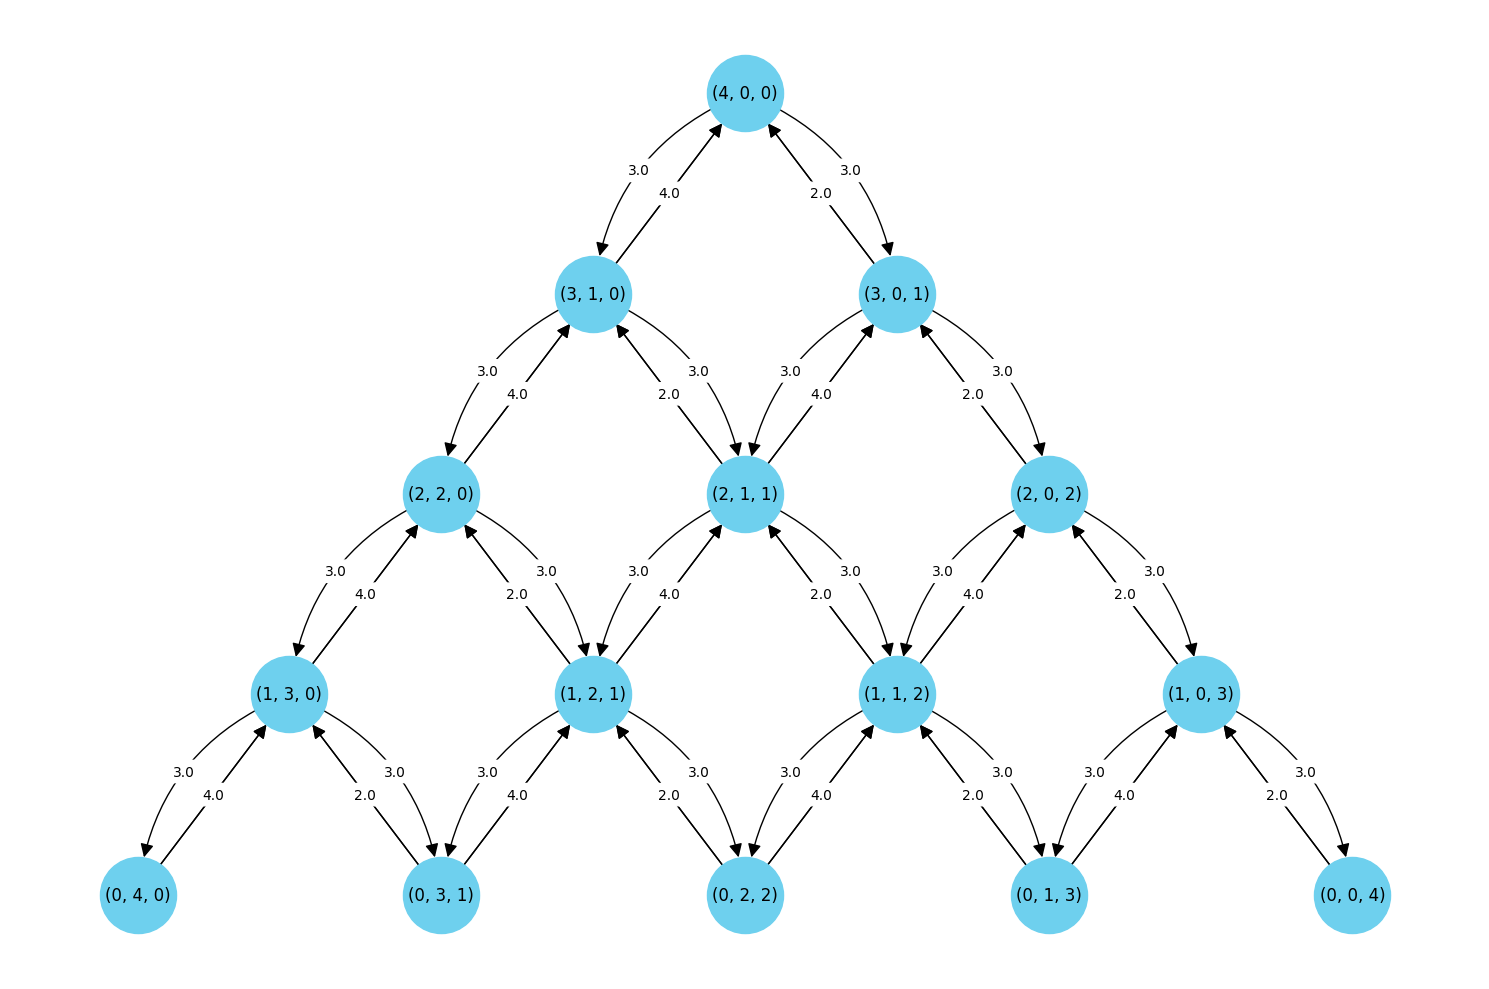

,Estado,Probabilidade
0,"(4, 0, 0)",0.0429
1,"(3, 1, 0)",0.0322
2,"(3, 0, 1)",0.0643
3,"(2, 2, 0)",0.0241
4,"(2, 1, 1)",0.0482
5,"(2, 0, 2)",0.0965
6,"(1, 3, 0)",0.0181
7,"(1, 2, 1)",0.0362
8,"(1, 1, 2)",0.0723
9,"(1, 0, 3)",0.1447


,X_0 (trans/min),R (segundos),U_CPU,U_Disco Rápido,U_Disco Lento
0,3.477,69.0250,0.5795,0.4346,0.8691


In [154]:
N = 4
K = 3
service_times = [10, 15, 30]
custom_labels = ["CPU", "Disco Rápido", "Disco Lento"]
transitions_type = 'continuous'

# Define the transition probabilities for the gym equipment based on the exercise
transition_probs = {
    (0, 1): 0.5,  # CPU para disco rápido
    (0, 2): 0.5,  # CPU para disco lento
    (1, 0): 1,
    (2, 0): 1,
}

states = generate_states(N, K)
edges = generate_edges(N, service_times, states, transition_probs, transitions_type)
A, b = generate_system(states, edges)
print(A, b)
draw_network_graph(K, N, states, edges, '15estados')
probabilities = solveSystem(A, b, states)

U_dict, X_0, R_seconds = calculate_metrics(N, K, probabilities, service_times, custom_labels=custom_labels)

results = {
    "X_0 (trans/min)": X_0,
    "R (segundos)": R_seconds,
    **U_dict
}

# Display the results
display(pd.DataFrame([results]))


## Questão 1

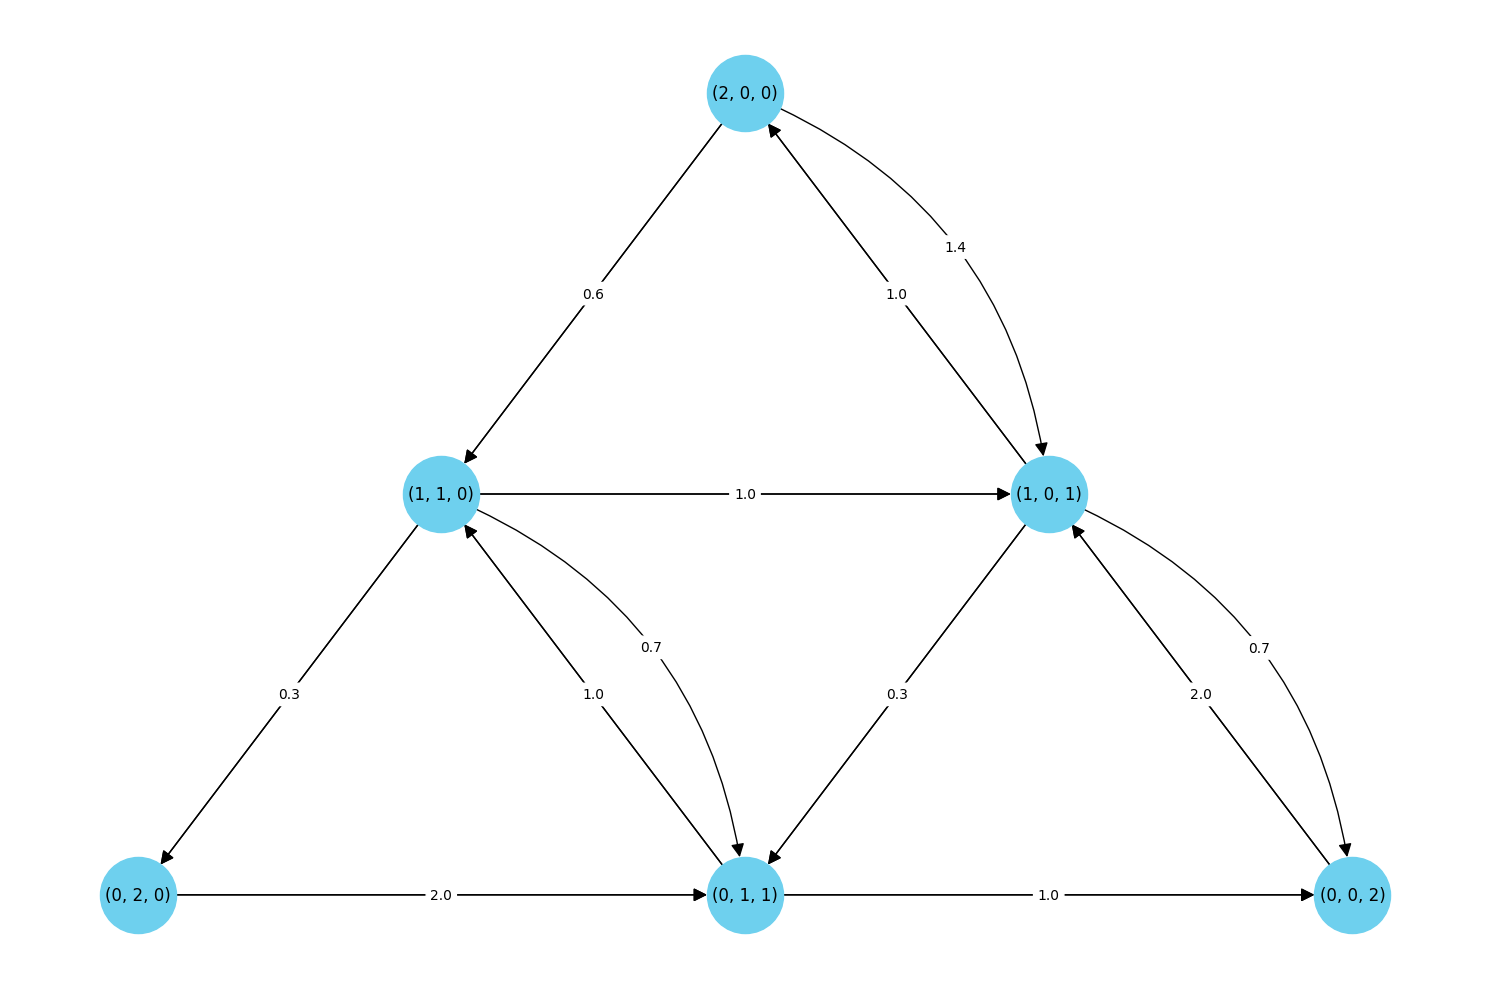

,Estado,Probabilidade
0,"(2, 0, 0)",0.1890
1,"(1, 1, 0)",0.1134
2,"(1, 0, 1)",0.3781
3,"(0, 2, 0)",0.0170
4,"(0, 1, 1)",0.1134
5,"(0, 0, 2)",0.1890


,U_i,Value
0,Esteira,0.6805
1,Bicicleta,0.1304
2,Elíptico,0.6805


,X_i,Value
0,Esteira,0.2268
1,Bicicleta,0.0435
2,Elíptico,0.2268


,X_0 (usuários/hora),R (minutos),V_esteira
0,4.5360,26.4550,3.0


In [155]:
# QUESTAO 1
N = 2
K = 3

service_times = [3, 3, 3] # tempo em minutos
resources = {
    "Esteira": 0,
    "Bicicleta": 1,
    "Elíptico": 2
}
V_eliptico = 3

multiprog_level = {
    "Bicicleta": 2,
}

# Define the transition probabilities for the gym equipment based on the exercise
transition_probs = {
    (resources["Esteira"], resources["Bicicleta"]): .3,
    (resources["Esteira"], resources["Elíptico"]): .7,
    (resources["Bicicleta"], resources["Elíptico"]): 1,
    (resources["Elíptico"], resources["Esteira"]): 1
}

states = generate_states(N, K)
edges = generate_edges(N, service_times, states, transition_probs)
A, b = generate_system(states, edges)

draw_network_graph(K, N, states, edges, 'questao1')
probabilities = solveSystem(A, b, states)

U_dict, X_dict = calculate_metrics2(K, probabilities, service_times, resources, multiprog_level=multiprog_level, factor=1)

X_0 = X_dict['Elíptico'] / V_eliptico
R = N / X_0

V_esteira = X_dict['Esteira'] / X_0

results = {
    "X_0 (usuários/hora)": f"{(X_0 * 60):.4f}",
    "R (minutos)": f"{R:.4f}",
    "V_esteira": V_esteira
}

# Display the results
display(pd.DataFrame(list(U_dict.items()), columns=['U_i', 'Value']))
display(pd.DataFrame(list(X_dict.items()), columns=['X_i', 'Value']))
display(pd.DataFrame([results]))


## Questão 2

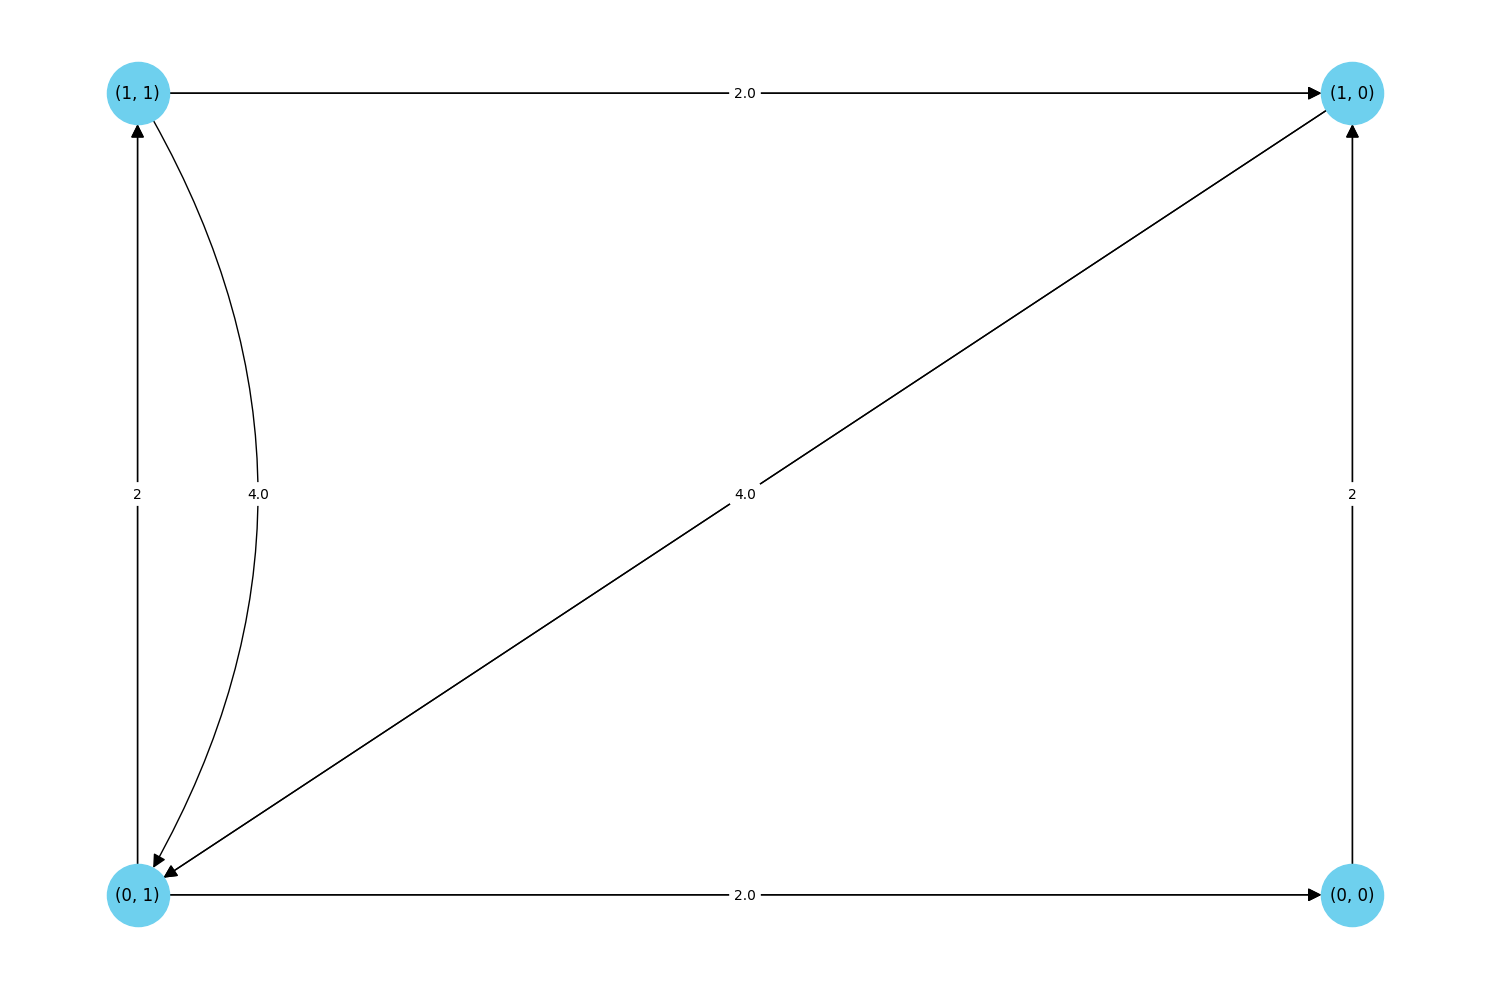

,Estado,Probabilidade
0,"(0, 0)",0.3333
1,"(1, 0)",0.2222
2,"(1, 1)",0.1111
3,"(0, 1)",0.3333


,U_i,Value
0,Servidor A,0.3333
1,Servidor B,0.4444


,X_i,Value
0,Servidor A,1.3332
1,Servidor B,0.8888


,Metric,Value
0,N,0.7777
1,X_0 (trans/min),1.3332
2,R (segundos ),0.5833


In [156]:
# QUESTAO 2
K = 2
N = 2
lambda_system = 2
service_times = [1/4, 1/2]

resources = {
    "Servidor A": {
        'min_users': 0,
        'max_users': 1,
        'index': 0,
    },
    "Servidor B": {
        'min_users': 0,
        'max_users': 1,
        'index': 1,
    },
}

states = [(0,0), (1,0), (1,1), (0,1)]

transition_probs = {
    (None, resources["Servidor A"]['index']): 1,
    (resources["Servidor A"]['index'], resources["Servidor B"]['index']): 1, 
    (resources["Servidor B"]['index'], None): 1,   
}

initial_resources = [transition[1] for transition in transition_probs if transition[0] is None]
initial_states = [state for state in states if state[0] in initial_resources and sum(state) != max(sum(state) for state in states)]

edges = generate_edges3(states, service_times, lambda_system, transition_probs, resources)

A, b = generate_system(states, edges)

draw_network_graph(K, N, states, edges, 'questao2')
probabilities = solveSystem(A, b, states)

U_dict, X_dict, N_avg, X_0, R_unit = calculate_metrics3(K, initial_states, probabilities, service_times, resources, factor=1, lambda_system=lambda_system)

results = {
    "N": N_avg,
    "X_0 (trans/min)": X_0,
    "R (segundos    )": R_unit,
}

display(pd.DataFrame(list(U_dict.items()), columns=['U_i', 'Value']))
display(pd.DataFrame(list(X_dict.items()), columns=['X_i', 'Value']))
display(pd.DataFrame(list(results.items()), columns=['Metric', 'Value']))

## Questão 3

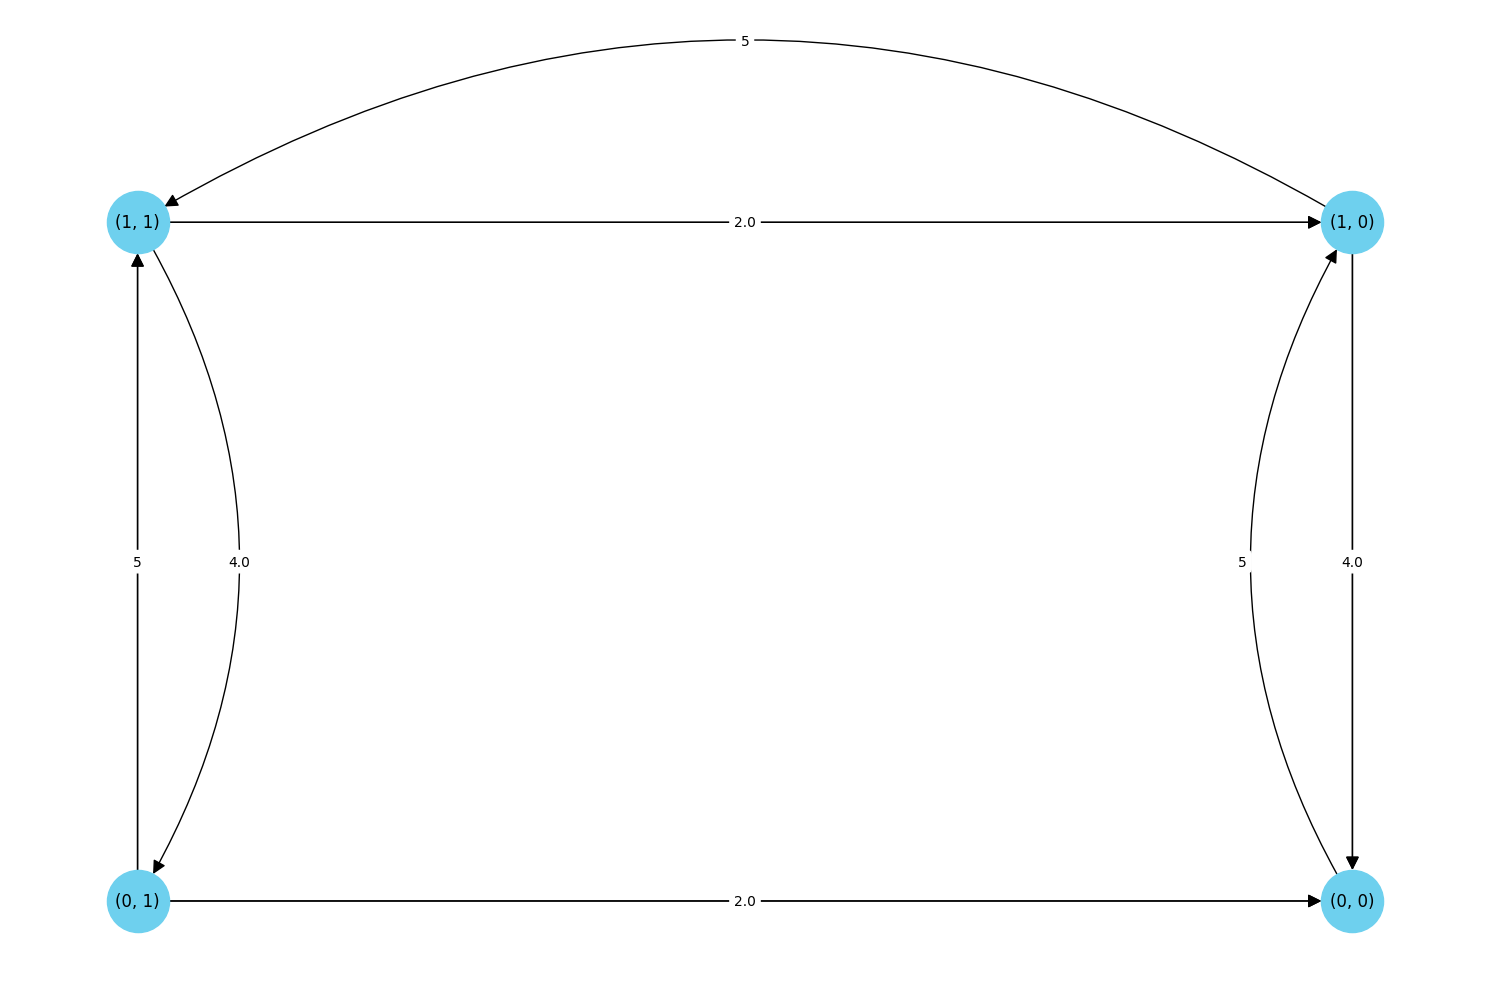

,Estado,Probabilidade
0,"(0, 0)",0.2495
1,"(1, 0)",0.2144
2,"(1, 1)",0.3411
3,"(0, 1)",0.1949


,U_i,Value
0,Servidor A,0.5555
1,Servidor B,0.5360


,X_i,Value
0,Servidor A,2.222
1,Servidor B,1.072


,Metric,Value
0,N,1.0915
1,X_0 (trans/min),3.294
2,R (segundos),0.3314


In [157]:
# QUESTAO 3
K = 2
N = 2
lambda_system = 5
service_times = [1/4, 1/2]

resources = {
    "Servidor A": {
        'min_users': 0,
        'max_users': 1,
        'index': 0,
    },
    "Servidor B": {
        'min_users': 0,
        'max_users': 1,
        'index': 1,
    },
}

resources_index = {index: resource for index, resource in enumerate(resources)}

states = [(0,0), (1,0), (1,1), (0,1)]

transition_probs = {
    (None, resources["Servidor A"]['index']): 1,
    (None, resources["Servidor B"]['index']): 1,
    (resources["Servidor A"]['index'], None): 1, 
    (resources["Servidor B"]['index'], None): 1,
}

transition_origins = {
    (None, resources["Servidor B"]['index']): (1, 0),
}

initial_resources = [transition[1] for transition in transition_probs if transition[0] is None]
initial_states = [state for state in states if state[0] in initial_resources and sum(state) != max(sum(state) for state in states)]

edges = generate_edges3(states, service_times, lambda_system, transition_probs, resources, transition_origins = transition_origins)
A, b = generate_system(states, edges)

draw_network_graph(K, N, states, edges, 'questao3')
probabilities = solveSystem(A, b, states)

U_dict, X_dict, N_avg, X_0, R = calculate_metrics3(K, initial_states, probabilities, service_times, resources, factor=1, lambda_system=lambda_system)

results = {
    "N": N_avg,
    "X_0 (trans/min)": X_0,
    "R (segundos)": R,
}

display(pd.DataFrame(list(U_dict.items()), columns=['U_i', 'Value']))
display(pd.DataFrame(list(X_dict.items()), columns=['X_i', 'Value']))
display(pd.DataFrame(list(results.items()), columns=['Metric', 'Value']))



## Questão 4

[1, 2, 2] [1, 1, 1]


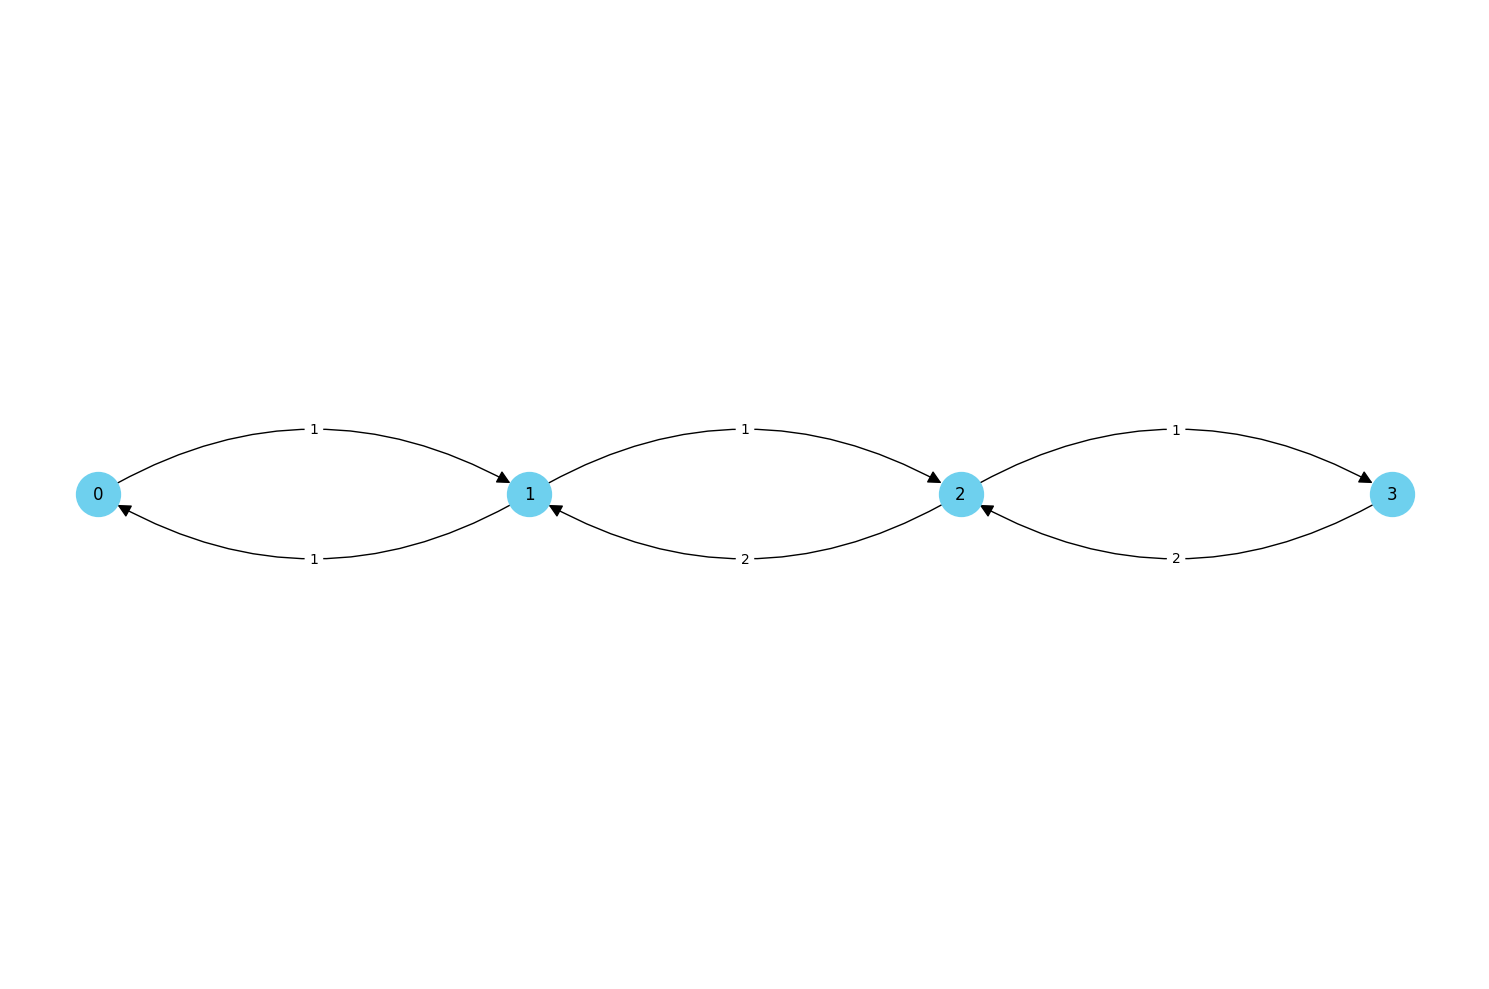

,Estado,Probabilidade
0,0,0.3636
1,1,0.3636
2,2,0.1818
3,3,0.0909


,Metric,Value
0,N,0.9999
1,loss_rate,0.0909
2,X_0,0.9090
3,R,1.1000
4,U,0.6364


a) 0.1818
b) 0.9090 jobs/s
c) 471225,60 R$


In [158]:
# QUESTAO 4
M = 2
B = 3
m = 3
K = 2
lambdaValue = 1
custom_lambdas = []
lambdas = [ lambdaValue if lambdaValue != None else custom_lambdas[i] for i in range(0, B)]
muValue = None
custom_mus = [ M if i >= M else i + 1 for i in range(0, B)]
mus = [ muValue if muValue != None else custom_mus[i] for i in range(0, B)]

print(mus, lambdas)
states = generate_states_birthdeath(B)
edges = generate_edges_birthdeath(states, lambdas, mus)

draw_network_graph_birthdeath(B, states, edges, 'questao4')

A, b = generate_system(states, edges)
probabilities = solveSystem(A, b, states)

results = calculate_birth_death_metrics(B, lambdaValue, mus, probabilities)
display(pd.DataFrame(list(results.items()), columns=['Metric', 'Value']))

# letra a) suponha que existem exatamente dois jobs no sistema. Qual é a probabilidade de um job chegar antes de um job completar?
#R: Um job chega no sistema antes de outro job completar quando temos 2 usuários usando o sistema, então é a probabilidade do estado 2
print('a)', probabilities[2])

# letra b) qual é o throughput do sistema?
print('b)', f"{results['X_0']:.4f} jobs/s")

# letra c) se a empresa dona do sistema de servidores ganha R$ 0.20 por job processado, qual
# seria o faturamento mensal da empresa? Considere que o servidor funciona 24 horas por dia.
# R: Seria o throughput x 0,2 R$ x 60 (s) x 60 (m) x 24 (h) x 30 d
X_0 = float(f"{results['X_0']:.4f}")
print('c)', f"{locale.currency(( X_0 * 0.2 * 60 * 60 * 24 * 30))}")


# soma = 0
# mult = 0
# for k in range(0, m+1):
#     # print(k)
#     for i in range(0, k):
#         mult = mult * (lambdas[i] / mus[i]) if mult != 0 else (lambdas[i] / mus[i])
#         print(k, i, mult)
#     soma = soma + mult

# print(1 / (1 + soma))

## Questão 5

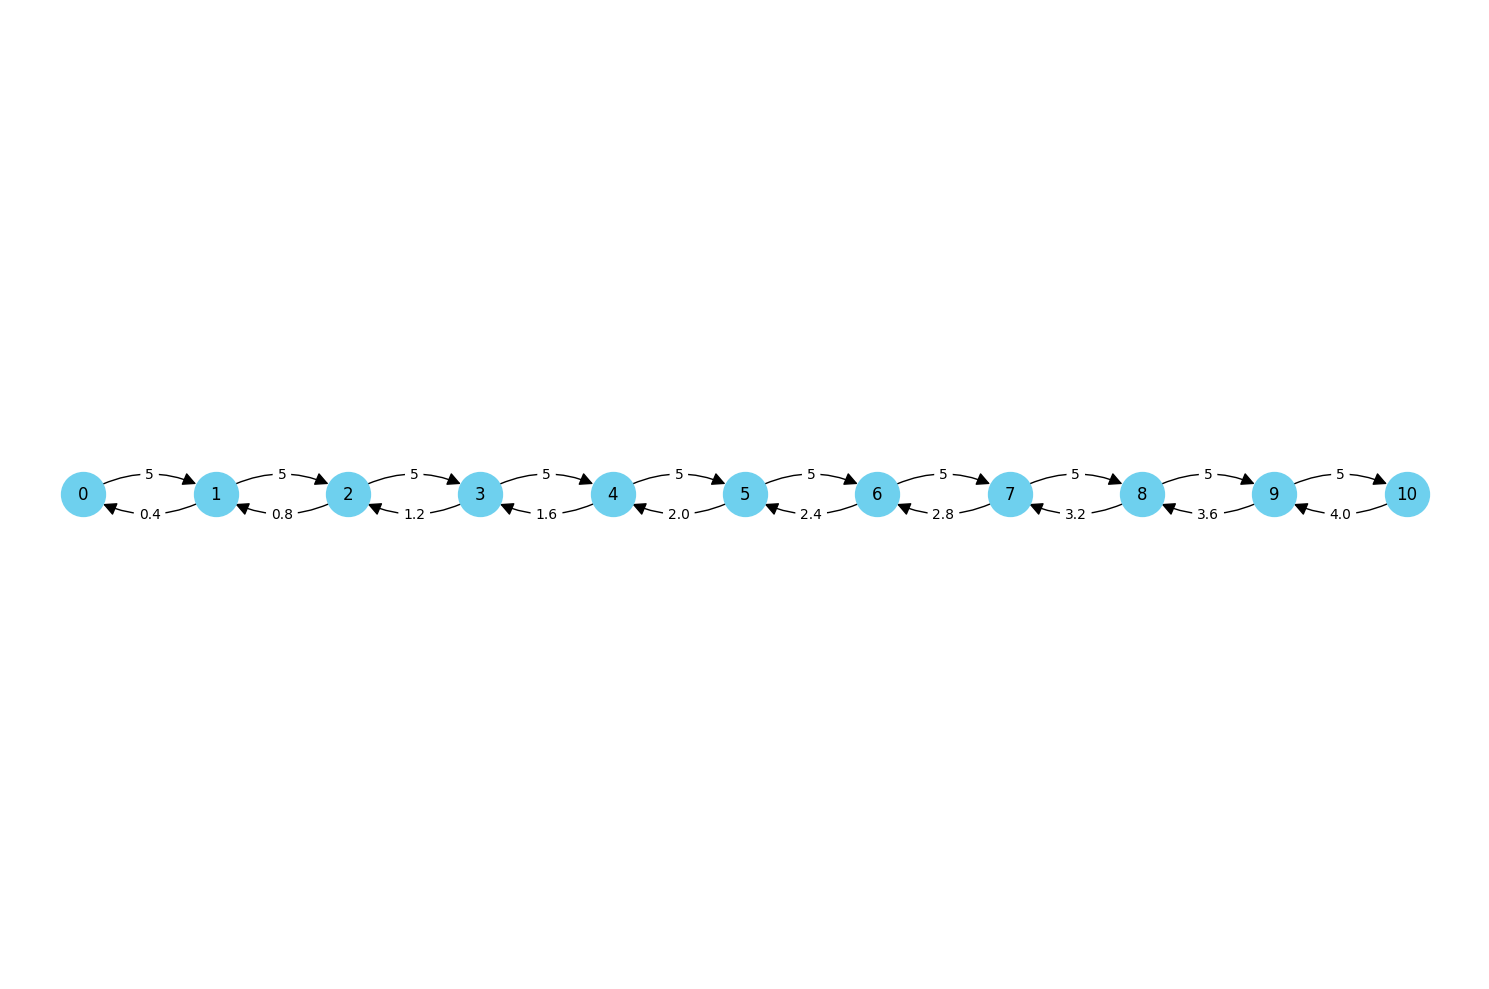

,Estado,Probabilidade
0,0,0.0000
1,1,0.0002
2,2,0.0010
3,3,0.0041
4,4,0.0128
5,5,0.0319
6,6,0.0665
7,7,0.1187
8,8,0.1854
9,9,0.2576


,Metric,Value
0,N,8.47670
1,loss_rate,1.61000
2,X_0,3.39068
3,R,2.50000
4,U,1.00000


In [159]:
# QUESTAO 5
M = 10
B = 10
K = 1
lambdaValue = 5
custom_lambdas = []
lambdas = [ lambdaValue if lambdaValue != None else custom_lambdas[i] for i in range(0, B)]
muValue = 1 / 2.5
custom_mus = [ M if i >= M else i + 1 for i in range(0, B)]
mus = [ float(f"{(muValue * i):.2f}") for i in range(1, B+1)]

states = generate_states_birthdeath(B)
edges = generate_edges_birthdeath(states, lambdas, mus)

draw_network_graph_birthdeath(B, states, edges, 'questao5')

A, b = generate_system(states, edges)
probabilities = solveSystem(A, b, states)

results = calculate_birth_death_metrics(B, lambdaValue, mus, probabilities)
display(pd.DataFrame(list(results.items()), columns=['Metric', 'Value']))



## Questão 6

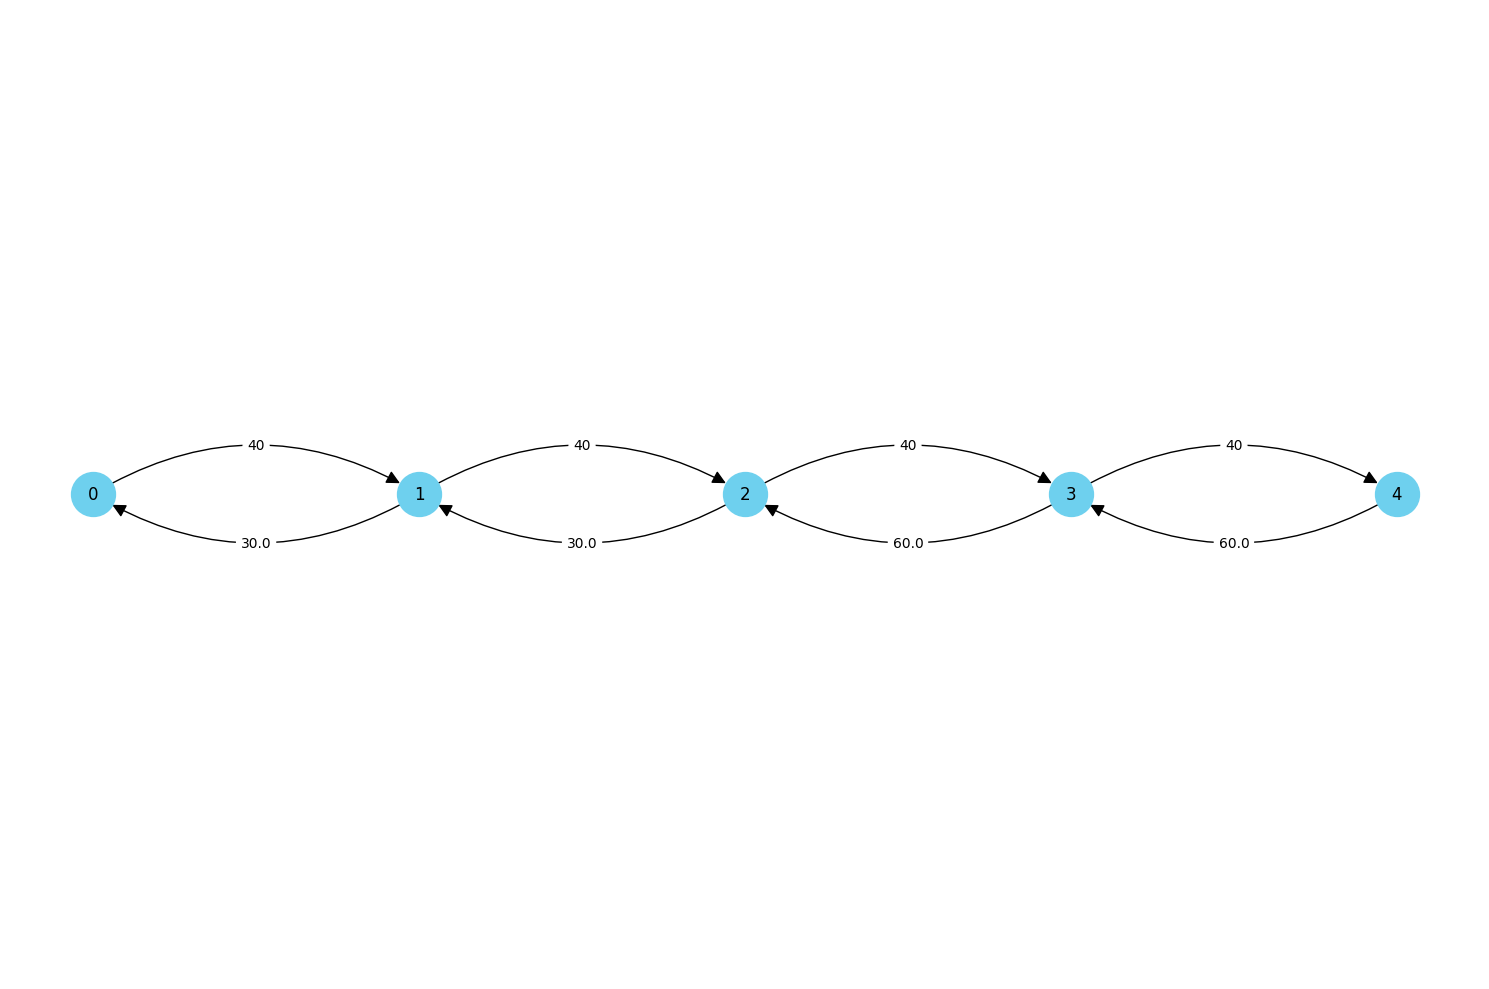

,Estado,Probabilidade
0,0,0.1643
1,1,0.2191
2,2,0.2921
3,3,0.1947
4,4,0.1298


,Metric,Value
0,N,1.906600
1,loss_rate,5.192000
2,X_0,34.806000
3,R,0.054778
4,U,0.835700


In [160]:
#QUESTAO 6
M = 4
B = 4
K = 2
lambdaValue = 40
custom_lambdas = []
lambdas = [ lambdaValue if lambdaValue != None else custom_lambdas[i] for i in range(0, B)]
muValue = None
custom_mus = [ 1 / (1/60) if i >= 2 else 1 / (2/60) for i in range(0, B)]
mus = [ muValue if muValue != None else custom_mus[i] for i in range(0, B)]

states = generate_states_birthdeath(B)
edges = generate_edges_birthdeath(states, lambdas, mus)

draw_network_graph_birthdeath(B, states, edges, 'questao6')

A, b = generate_system(states, edges)
probabilities = solveSystem(A, b, states)

results = calculate_birth_death_metrics(B, lambdaValue, mus, probabilities)
display(pd.DataFrame(list(results.items()), columns=['Metric', 'Value']))
